# Loggable Dataset Example Notebook

 showcases the usage of `DatasetManifest`, `FileState`, and `BaseImageDataset` classes for handling image datasets in a loggable and reproducible manner. It demonstrates how to construct a file index, retrieve image paths, load images, and configure input/target channels for training different models. The notebook also covers the logging capabilities of the `BaseImageDataset` class, allowing for reproducible re-creation of datasets from logged artifacts.

### Dependencies

In [1]:
import json
import yaml
import pathlib

import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from virtual_stain_flow.datasets.base_dataset import BaseImageDataset
from virtual_stain_flow.datasets.manifest import DatasetManifest, FileState

### Retrieve Demo Data

In [2]:
ANALYSIS_REPO_ROOT = pathlib.Path('.').absolute().parent / 'pediatric_cancer_atlas_analysis'
CONFIG_PATH = ANALYSIS_REPO_ROOT / 'config.yml'
config = yaml.safe_load(CONFIG_PATH.read_text())

LOADDATA_FILE_PATH = ANALYSIS_REPO_ROOT / '0.data_preprocessing' / 'data_split_loaddata' / 'loaddata_train.csv'
PROFILING_DIR = pathlib.Path(config['paths']['pediatric_cancer_atlas_profiling_path'])
SC_FEATURES_DIR = pathlib.Path(config['paths']['sc_features_path'])

for path in [ANALYSIS_REPO_ROOT, CONFIG_PATH, LOADDATA_FILE_PATH]:
    if not path.exists():
        raise FileNotFoundError(f"File/Directory not found: {path}")

loaddata_df = pd.read_csv(LOADDATA_FILE_PATH)

Demo image data are .tiff files indexed by pe2loaddata generated loaddata csv files.
Each row represents a sample/field of view with metadata columns as well as file path/name columns.

In [3]:
print(loaddata_df.head())

   Unnamed: 0 Metadata_Plate  time_point          platemap_file cell_line row  \
0           0     BR00143976          24  Assay_Plate1_platemap     U2-OS   M   
1           1     BR00143976          24  Assay_Plate1_platemap     U2-OS   M   
2           2     BR00143976          24  Assay_Plate1_platemap     U2-OS   M   
3           3     BR00143976          24  Assay_Plate1_platemap     U2-OS   M   
4           4     BR00143976          24  Assay_Plate1_platemap     U2-OS   M   

   column Metadata_Well  seeding_density        FileName_OrigBrightfield  ...  \
0      13           M13             1000  r13c13f01p01-ch1sk1fk1fl1.tiff  ...   
1      13           M13             1000  r13c13f02p01-ch1sk1fk1fl1.tiff  ...   
2      13           M13             1000  r13c13f03p01-ch1sk1fk1fl1.tiff  ...   
3      13           M13             1000  r13c13f04p01-ch1sk1fk1fl1.tiff  ...   
4      13           M13             1000  r13c13f05p01-ch1sk1fk1fl1.tiff  ...   

  Metadata_AbsPositionZ Me

For demoing the loggable dataset class, we just extract the columns representing tiff image paths and construct a pure file index dataframe, with each row representing a field of view, columns being all the channels, and each cell being the full filepath corresponding to the image file of the channel and field of view combination.

In [4]:
filename_cols = loaddata_df.columns
filename_cols = [col for col in filename_cols if col.startswith('FileName_')]
filepath_cols = loaddata_df.columns
filepath_cols = [col for col in filepath_cols if col.startswith('PathName_')]

channel_strip_name_cols = [
    col.replace('FileName_', '')
    for col in filename_cols
]
channel_strip_path_cols = [
    col.replace('PathName_', '')
    for col in filepath_cols
]
channel_union = set(channel_strip_name_cols) & set(channel_strip_path_cols)
channel_union = list(channel_union)

file_index_df = pd.DataFrame(columns=channel_union, index=loaddata_df.index)
for channel in channel_union:
    file_index_df[channel] = loaddata_df.apply(
        lambda row: pathlib.Path(row[f'PathName_{channel}']) / str(row[f'FileName_{channel}']), axis=1)

file_index_df = file_index_df.reset_index(drop=True, inplace=False)
print(file_index_df.head())

                                             OrigRNA  \
0  /home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...   
1  /home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...   
2  /home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...   
3  /home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...   
4  /home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...   

                                              OrigER  \
0  /home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...   
1  /home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...   
2  /home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...   
3  /home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...   
4  /home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...   

                                            OrigMito  \
0  /home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...   
1  /home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...   
2  /home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...   
3  /home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...   
4  /home/weishanli/Waylab/ALSF_pilot/data/ALSF

### Showcase of `DatasetManifest`
The DatasetManifest defines the immutable component of a dataset, which is simply the file index dataframe plus a pil image mode string.

In [5]:
manifest = DatasetManifest(
    file_index = file_index_df,
    pil_image_mode = 'I;16'  # 16-bit grayscale images
)
print(f"DatasetManifest with {len(manifest)} samples and {manifest.n_channels} number of channels.")
print(f"Channel keys: {manifest.channel_keys}")

DatasetManifest with 402 samples and 6 number of channels.
Channel keys: ['OrigRNA', 'OrigER', 'OrigMito', 'OrigBrightfield', 'OrigAGP', 'OrigDNA']


Using `get_paths_for_keys` allows for retrieval of the image full paths as list of the `idx`th field of view for all channel keys specified by `keys`.

In [6]:
image_paths = manifest.get_paths_for_keys(
    idx=0,
    keys=manifest.channel_keys[:1] # here we only get the path for the first channel
)
print(image_paths)

[PosixPath('/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pilot_data/SN0313537/BR00143976__2024-07-04T16_04_45-Measurement 2/Images/r13c13f01p01-ch6sk1fk1fl1.tiff')]


`get_paths_for_keys` can be used in conjunction with `read_image` to load the tiff image

(np.float64(-0.5), np.float64(1079.5), np.float64(1079.5), np.float64(-0.5))

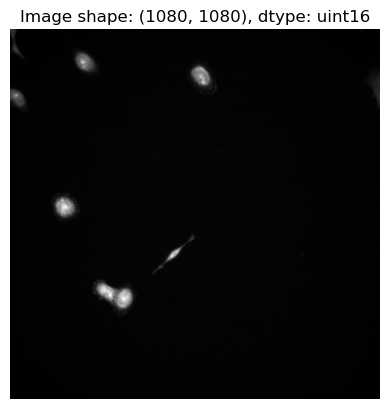

In [7]:
image = manifest.read_image(image_paths[0])

plt.imshow(image, cmap='gray')
plt.title(f"Image shape: {image.shape}, dtype: {image.dtype}")
plt.axis('off')

### `DatasetManifest` can be used in conjunction with `FileState` to achieve lazy, dynamica image loading. 

In [8]:
state = FileState(
    manifest=manifest,
    # setting the cache capacity to None (default) will automatically set make the capacity to be the number of channels
    # this enables caching of the full image stack for one fov
    cache_capacity=None
)

Without any updating of the initialized `FileState`, the state attributes will be empty:

In [9]:
print(f"Default input_path state: {state.input_paths}")
print(f"Default target_path state: {state.target_paths}")
print(f"Default input_image state: {state.input_image_raw}")
print(f"Default target_image state: {state.target_image_raw}")

Default input_path state: []
Default target_path state: []
Default input_image state: None
Default target_image state: None


To retrieve image lazily through `FileState`, simply `.update()` it and then access the attributes:

In [10]:
state.update(
    idx=0,
    input_keys=['OrigBrightfield'],
    target_keys=['OrigDNA']
)
print(f"Default input_path state: {state.input_paths}")
print(f"Default target_path state: {state.target_paths}")
print(f"Default input_image state: {state.input_image_raw.shape}")
print(f"Default target_image state: {state.target_image_raw.shape}")

Default input_path state: [PosixPath('/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pilot_data/SN0313537/BR00143976__2024-07-04T16_04_45-Measurement 2/Images/r13c13f01p01-ch1sk1fk1fl1.tiff')]
Default target_path state: [PosixPath('/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pilot_data/SN0313537/BR00143976__2024-07-04T16_04_45-Measurement 2/Images/r13c13f01p01-ch5sk1fk1fl1.tiff')]
Default input_image state: (1, 1080, 1080)
Default target_image state: (1, 1080, 1080)


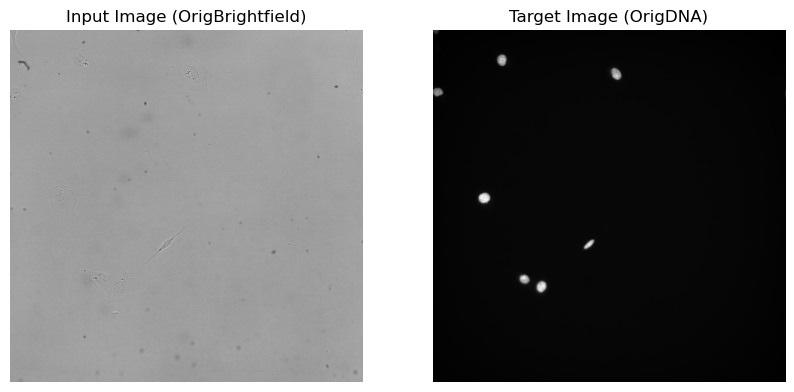

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(state.input_image_raw[0], cmap='gray')
axes[0].set_title('Input Image (OrigBrightfield)')
axes[0].axis('off')
axes[1].imshow(state.target_image_raw[0], cmap='gray')
axes[1].set_title('Target Image (OrigDNA)')
axes[1].axis('off')
plt.show()

### `BaseImageDataset` demo
The dataset class internally initializes the `DatasetManifest` and `FileState` infranstructure showcased above.

In [12]:
dataset = BaseImageDataset(
    file_index=file_index_df,
    pil_image_mode='I;16',
    # the user may choose to configure the input and target channels 
    # at dataset initialization, or leave it as default (None) and set it later
    # with setter methods
    input_channel_keys=['OrigBrightfield'],
    target_channel_keys=['OrigDNA'],
    # cache capacity parameter passed to the underlying FileState instance
    cache_capacity=None
)
print(f"Dataset with {len(dataset)} samples.")

Dataset with 402 samples.


Paired input/target image stacks can be retrieved through the overidden `torch.Dataset` `__getitem__` method as tensors

In [13]:
input, target = dataset[0]
print(f"Input tensor shape: {input.shape}, dtype: {input.dtype}")
print(f"Target tensor shape: {target.shape}, dtype: {target.dtype}")

Input tensor shape: torch.Size([1, 1080, 1080]), dtype: torch.float32
Target tensor shape: torch.Size([1, 1080, 1080]), dtype: torch.float32


or through the `get_raw_item` method as numpy arrays

Input array shape: (1, 1080, 1080), dtype: uint16
Target array shape: (1, 1080, 1080), dtype: uint16


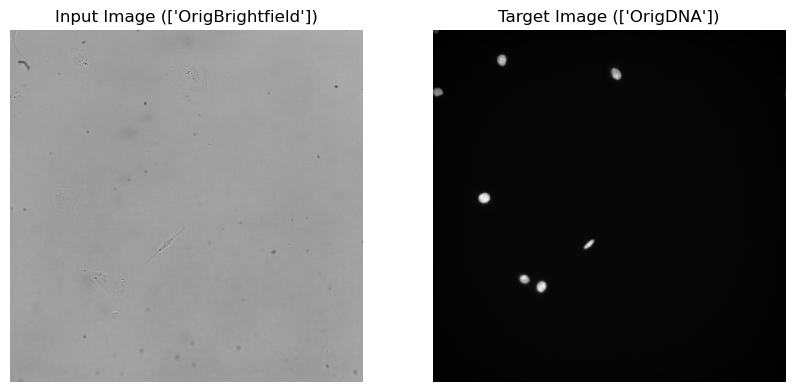

In [14]:
input, target = dataset.get_raw_item(0)
print(f"Input array shape: {input.shape}, dtype: {input.dtype}")
print(f"Target array shape: {target.shape}, dtype: {target.dtype}")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input[0], cmap='gray')
axes[0].set_title(f'Input Image ({dataset.input_channel_keys})')
axes[0].axis('off')
axes[1].imshow(target[0], cmap='gray')
axes[1].set_title(f'Target Image ({dataset.target_channel_keys})')
axes[1].axis('off')
plt.show()

Input/Target channel keys can be configured/changed after initialization to train different channel predicting models without re-creating the entire dataset.

Input array shape: (1, 1080, 1080), dtype: uint16
Target array shape: (1, 1080, 1080), dtype: uint16


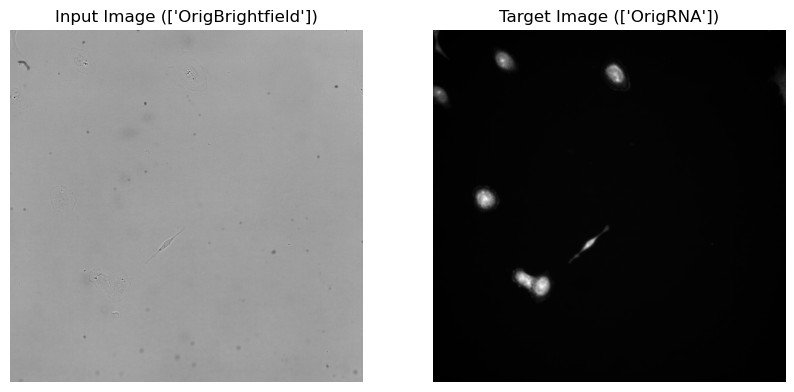

In [15]:
dataset.input_channel_keys = ['OrigBrightfield'] # input unchanged
dataset.target_channel_keys = ['OrigRNA'] # target as OrigRNA channel

input, target = dataset.get_raw_item(0)
print(f"Input array shape: {input.shape}, dtype: {input.dtype}")
print(f"Target array shape: {target.shape}, dtype: {target.dtype}")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input[0], cmap='gray')
axes[0].set_title(f'Input Image ({dataset.input_channel_keys})')
axes[0].axis('off')
axes[1].imshow(target[0], cmap='gray')
axes[1].set_title(f'Target Image ({dataset.target_channel_keys})')
axes[1].axis('off')
plt.show()

#### To faciliate logging, the dataset class comes with `to_config` methods

In [16]:
print(dataset.to_config())

{'file_index': {'records': [{'OrigRNA': '/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pilot_data/SN0313537/BR00143976__2024-07-04T16_04_45-Measurement 2/Images/r13c13f01p01-ch6sk1fk1fl1.tiff', 'OrigER': '/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pilot_data/SN0313537/BR00143976__2024-07-04T16_04_45-Measurement 2/Images/r13c13f01p01-ch2sk1fk1fl1.tiff', 'OrigMito': '/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pilot_data/SN0313537/BR00143976__2024-07-04T16_04_45-Measurement 2/Images/r13c13f01p01-ch4sk1fk1fl1.tiff', 'OrigBrightfield': '/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pilot_data/SN0313537/BR00143976__2024-07-04T16_04_45-Measurement 2/Images/r13c13f01p01-ch1sk1fk1fl1.tiff', 'OrigAGP': '/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pilot_data/SN0313537/BR00143976__2024-07-04T16_04_45-Measurement 2/Images/r13c13f01p01-ch3sk1fk1fl1.tiff', 'OrigDNA': '/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pilot_data/SN0313537/BR00143976__2024-07-04T16_04_45-Measurement 2/Images/r13c13f01p01-ch5sk

the `to_json_config` creates JSON file loggable as mlflow artifacts

In [17]:
dataset.to_json_config(filepath='example_dataset_config.json')
!head -n 10 example_dataset_config.json

{
  "file_index": {
    "records": [
      {
        "OrigRNA": "/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pilot_data/SN0313537/BR00143976__2024-07-04T16_04_45-Measurement 2/Images/r13c13f01p01-ch6sk1fk1fl1.tiff",
        "OrigER": "/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pilot_data/SN0313537/BR00143976__2024-07-04T16_04_45-Measurement 2/Images/r13c13f01p01-ch2sk1fk1fl1.tiff",
        "OrigMito": "/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pilot_data/SN0313537/BR00143976__2024-07-04T16_04_45-Measurement 2/Images/r13c13f01p01-ch4sk1fk1fl1.tiff",
        "OrigBrightfield": "/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pilot_data/SN0313537/BR00143976__2024-07-04T16_04_45-Measurement 2/Images/r13c13f01p01-ch1sk1fk1fl1.tiff",
        "OrigAGP": "/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pilot_data/SN0313537/BR00143976__2024-07-04T16_04_45-Measurement 2/Images/r13c13f01p01-ch3sk1fk1fl1.tiff",
        "OrigDNA": "/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pilot_data/SN0313537/BR00143

Class function allows for reproducible re-creation of dataset from logged artifacts

In [18]:
json_config_loaded = json.load(open('example_dataset_config.json', 'r'))
dataset_loaded = BaseImageDataset.from_config(json_config_loaded)
print(f"Dataset with {len(dataset_loaded)} samples.")

Dataset with 402 samples.


In [19]:
!rm -f example_dataset_config.json